In [ ]:


import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [25]:
# Paths
dataset_path = 'C:\\Users\\jokku\\Major Project\\Model_w_longdata\\Longer_data'  # New dataset path with longer audio files

# Parameters
num_classes = 5
sr = 22050  # Sampling rate for loading audio
n_mels = 128
max_duration = 20  # Max duration in seconds for each longer audio file

In [26]:
# Data preparation
# X = []
# y = []
# class_labels = sorted(os.listdir(dataset_path)) 
# print(class_labels) # Sort class folders alphabetically for consistency

# for label, class_folder in enumerate(class_labels):
#     class_path = os.path.join(dataset_path, class_folder)
    
#     for file_name in os.listdir(class_path):
#         file_path = os.path.join(class_path, file_name)
        
#         # Load audio file
#         y_audio, _ = librosa.load(file_path, sr=sr, duration=max_duration)
        
#         # Compute mel spectrogram
#         mel_spectrogram = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=n_mels, fmax=8000)
#         mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
#         # Add to dataset
#         X.append(mel_spectrogram_db)
#         y.append(label)

In [27]:
import librosa
import numpy as np
import os

# Parameters
max_duration = 20  # seconds
n_mels = 128
n_mfcc = 13  # Number of MFCC coefficients to extract
sr = 22050  # Sampling rate

# Data preparation
X = []
y = []
class_labels = sorted(os.listdir(dataset_path))  # Sort class folders alphabetically for consistency
print(class_labels)

['Abnormal  - Aortic Stenosis (AS)', 'Abnormal - Mitral Regurgitation (MR)', 'Abnormal - Mitral Stenosis (MS)', 'Abnormal - Mitral Valve Prolapse (MVP)', 'Normal (N)']


In [28]:
# Feature extraction
for label, class_folder in enumerate(class_labels):
    class_path = os.path.join(dataset_path, class_folder)

    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)

        # Load audio file
        y_audio, _ = librosa.load(file_path, sr=sr, duration=max_duration)

        # Compute mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=n_mels, fmax=8000)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Compute MFCC
        mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=n_mfcc)

        # Combine mel spectrogram and MFCC
        combined_features = np.vstack((mel_spectrogram_db, mfcc))

        # Add to dataset
        X.append(combined_features)
        y.append(label)

In [29]:
print(X[0])
print(y[0])
print(X[0].shape)

[[-65.24933    -42.146935   -34.794357   ... -67.499374   -59.217262
  -55.336655  ]
 [-58.47713    -37.04102    -28.137901   ... -66.25353    -53.829292
  -47.479893  ]
 [-43.910694   -25.428547   -14.233671   ... -57.738277   -47.732433
  -41.78222   ]
 ...
 [  1.2110575   -3.8654265   -2.9607692  ...   2.7632937    1.8189883
    0.11000614]
 [ -2.7952743   -6.3297915   -4.5263567  ...  -2.5900156    1.5027716
   -2.3042965 ]
 [ -5.2983575   -4.747982    -1.9361154  ...  -6.0236025    1.0330902
    4.128586  ]]
0
(141, 862)


In [30]:
# Helper function to pad or truncate
def pad_or_truncate(array, fixed_height, fixed_width):
    if len(array.shape) != 2:
        raise ValueError(f"Expected a 2D array, but got shape {array.shape}")

    padded = np.zeros((fixed_height, fixed_width))  # Initialize with zeros
    height, width = array.shape

    # Truncate if larger than the fixed size
    if width > fixed_width:
        padded[:, :fixed_width] = array[:, :fixed_width]
    else:  # Pad if smaller
        padded[:, :width] = array

    return padded

# Process features to ensure consistent shape
X_fixed = [pad_or_truncate(features, fixed_height, fixed_width) for features in X]

# Convert to numpy arrays
X = np.array(X_fixed)
y = np.array(y)

# Reshape X to add a channel dimension for CNN: (samples, height, width, channels)
X = X[..., np.newaxis]  # Add channel dimension

# Check shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (100, 141, 200, 1)
y shape: (100,)


In [31]:
print(X[0])

[[[-65.24932861]
  [-42.14693451]
  [-34.7943573 ]
  ...
  [-30.83236694]
  [-31.80220985]
  [-33.58451462]]

 [[-58.47713089]
  [-37.04101944]
  [-28.13790131]
  ...
  [-26.03375435]
  [-22.69748688]
  [-27.63032532]]

 [[-43.91069412]
  [-25.42854691]
  [-14.23367119]
  ...
  [-15.48991966]
  [-13.48919868]
  [-14.09573555]]

 ...

 [[  1.21105754]
  [ -3.86542654]
  [ -2.96076918]
  ...
  [  2.91578794]
  [  1.5644511 ]
  [ -1.50353873]]

 [[ -2.79527426]
  [ -6.32979155]
  [ -4.5263567 ]
  ...
  [-12.35969543]
  [ -8.88751888]
  [ -0.21868145]]

 [[ -5.29835749]
  [ -4.74798203]
  [ -1.93611538]
  ...
  [ -7.59536266]
  [ -2.17015839]
  [  6.11207438]]]


In [ ]:
#min-max normalization
X = (X - np.min(X)) / (np.max(X) - np.min(X))  # Min-max normalization
print(X[0])

[[[0.6217551 ]
  [0.64817467]
  [0.65658297]
  ...
  [0.66111385]
  [0.66000475]
  [0.65796653]]

 [[0.62949969]
  [0.65401372]
  [0.6641952 ]
  ...
  [0.66660147]
  [0.67041678]
  [0.66477566]]

 [[0.64615766]
  [0.66729358]
  [0.68009588]
  ...
  [0.67865925]
  [0.68094725]
  [0.68025362]]

 ...

 [[0.69775825]
  [0.69195286]
  [0.69298741]
  ...
  [0.69970776]
  [0.69816239]
  [0.69465388]]

 [[0.69317667]
  [0.68913464]
  [0.69119703]
  ...
  [0.68223893]
  [0.68620966]
  [0.69612322]]

 [[0.69031418]
  [0.69094358]
  [0.69415919]
  ...
  [0.68768735]
  [0.69389154]
  [0.70336298]]]


In [33]:
print(X.shape)

(100, 141, 200, 1)


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# One-hot encode labels
y = to_categorical(y, num_classes=len(np.unique(y)))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model with accuracy displayed after each epoch
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1  # This ensures accuracy is displayed for both training and validation
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the model
# model.save('audio_classification_model.h5')


C:\Users\jokku\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 139, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 139, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 69, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 69, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 67, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 67, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 33, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 33, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 31, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 44160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    11,305,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,400,069 (43.49 MB)

 Trainable params: 11,399,621 (43.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.1883 - loss: 17.5154 - val_accuracy: 0.1500 - val_loss: 1.6746
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.3508 - loss: 13.8994 - val_accuracy: 0.2500 - val_loss: 1.8811
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3742 - loss: 5.1531 - val_accuracy: 0.2500 - val_loss: 1.7462
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3586 - loss: 4.4497 - val_accuracy: 0.2500 - val_loss: 1.5902
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5656 - loss: 1.4783 - val_accuracy: 0.1500 - val_loss: 4.1223
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6781 - loss: 0.8459 - val_accuracy: 0.1500 - val_loss: 8.5024
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6953 - loss: 0.8389 - val_accuracy: 0.1500 - val_loss: 13.3239
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7797 - loss: 0.7381 - val_accuracy: 0.1500 - val_loss: 18.1506
Epoch 9/3

In [22]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - accuracy: 0.3266 - loss: 26.8280
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.2000 - loss: 24.3751
Training Accuracy: 0.32
Test Accuracy: 0.20


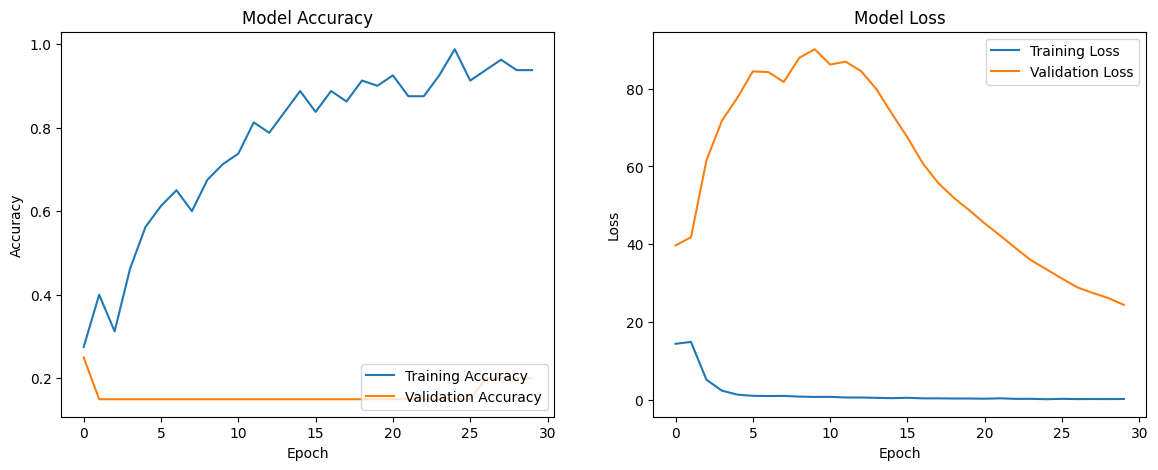

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.show()

In [ ]:
# Save the model in .h5 format
# model.save('heart_sound_classifier2.h5')
# print("Model saved as 'heart_sound_classifier.h5")

Model saved as 'heart_sound_classifier.h5


In [39]:
model_path = "C:\\Users\\jokku\\Major Project\\Model_w_longdata\\heart_sound_classifier2.h5"

# Load the saved model
loaded_model = tf.keras.models.load_model(model_path)
print("Model loaded successfully.")

# Class labels (adjust to your specific class names)
class_labels = ["AS", "MR", "MS", "MVP", "N"]

def predict_audio_file(file_path):
    # Load the audio file
    y_audio, sr = librosa.load(file_path, sr=22050, duration=10)
    
    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Reshape for model input (1 sample, height, width, channels)
    mel_spectrogram_db = mel_spectrogram_db[np.newaxis, ..., np.newaxis]
    
    # Predict the class
    prediction = loaded_model.predict(mel_spectrogram_db)
    predicted_class = class_labels[np.argmax(prediction)]
    
    # Output prediction details
    print(f"Predicted Class: {predicted_class}")
    print(f"Prediction Probabilities: {prediction[0]}")

# Example usage
# Replace 'your_test_file.wav' with the path to your provided test audio file
test_file_path = "C:\\Users\\jokku\\Major Project\\Model_w_longdata\\Longer_data\\Abnormal - Mitral Valve Prolapse (MVP)\\Abnormal - Mitral Valve Prolapse (MVP)_combined_5.wav"  # Update this path to your test file
predict_audio_file(test_file_path)

del loaded_model
print("Model Closed")

Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
Predicted Class: MVP
Prediction Probabilities: [0.1911507  0.21964358 0.18054622 0.23171102 0.17694844]
Model Closed


In [31]:
#
#conversion to TFlite

# Load the .h5 model
model = tf.keras.models.load_model("C:\\Users\\jokku\\Major Project\\Model_w_longdata\\heart_sound_classifier.h5")

# Convert to .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Optional: enable quantization for further optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the .tflite model
with open('heart_sound_classifier_optimized.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to 'heart_sound_classifier_optimized.tflite'")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\jokku\Major Project\Model_w_longdata\heart_sound_classifier.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="heart_sound_classifier_optimized.tflite")
interpreter.allocate_tensors()

# Get input and output details for the model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_audio(file_path):
    # Load the audio file and convert it to a mel spectrogram
    y_audio, sr = librosa.load(file_path, sr=22050, duration=10)
    mel_spectrogram = librosa.feature.melspectrogram(y=y_audio, sr=sr, n_mels=128, fmax=8000)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Reshape to match model input
    mel_spectrogram_db = mel_spectrogram_db[np.newaxis, ..., np.newaxis].astype(np.float32)
    return mel_spectrogram_db

def predict_audio_file_tflite(file_path):
    # Preprocess the audio file
    input_data = preprocess_audio(file_path)
    
    # Set the model input
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run the model
    interpreter.invoke()

    # Get the model output
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    # Decode the predictions
    predicted_class = class_labels[np.argmax(output_data)]
    
    print(f"Predicted Class: {predicted_class}")
    print(f"Prediction Probabilities: {output_data[0]}")

# Example usage
test_file_path = "C:\\Users\\jokku\\Major Project\\Model_w_longdata\\Longer_data\\Abnormal - Mitral Regurgitation (MR)\Abnormal - Mitral Regurgitation (MR)_combined_20.wav" # Replace with your test file path
predict_audio_file_tflite(test_file_path)